In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torchvision.datasets import DatasetFolder
import torchvision
from tqdm.notebook import tqdm as tqdm
from torchsampler import ImbalancedDatasetSampler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')
device = "cuda" if train_on_gpu else "cpu"

CUDA is available!


In [3]:
train_image_path = "/home/chisc/workspace/wuzhenrong/galaxy/eight_type/train/"
val_image_path = "/home/chisc/workspace/wuzhenrong/galaxy/eight_type/validation/"
test_image_path = "/home/chisc/workspace/wuzhenrong/galaxy/eight_type/test/"

In [4]:
batch_size = 32
train_trans = transforms.Compose([
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomRotation((-30, 30)),
                                  transforms.Resize((255, 255)),
#                                   transforms.CenterCrop(210),
#                                   transforms.Resize((255, 255)),
#                                   transforms.GaussianBlur(7,3),
#                                   transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
#                                   transforms.RandomCrop(size=(255, 255)),
                                  transforms.ToTensor()])

train_data = ImageFolder(train_image_path, transform = train_trans)
train_loader = DataLoader(train_data, pin_memory = True, batch_size = batch_size, sampler=ImbalancedDatasetSampler(train_data))

val_trans = transforms.Compose([transforms.Resize((255, 255)),transforms.ToTensor()])
val_data = ImageFolder(val_image_path, transform = val_trans)
val_loader = DataLoader(val_data, shuffle = True)

test_trans = transforms.Compose([transforms.Resize((255, 255)),transforms.ToTensor()])
test_data = ImageFolder(test_image_path, transform = test_trans)
test_loader = DataLoader(test_data, shuffle = True)

print('Train:', len(train_data))
print('Valid:', len(val_data))
print('Test:', len(test_data))

Train: 1923
Valid: 145
Test: 145


tensor([5, 2, 4, 1, 6, 5, 1, 3, 5, 2, 4, 0, 5, 3, 7, 2, 5, 7, 6, 3, 0, 6, 5, 5,
        5, 7, 3, 4, 1, 4, 2, 6])
tensor(5)


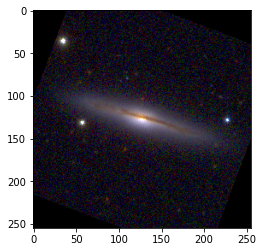

tensor(2)


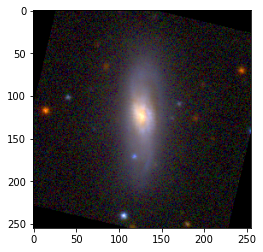

tensor(4)


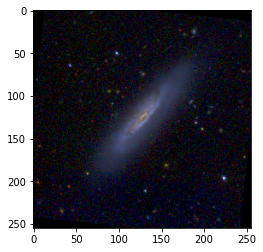

In [5]:
images, labels = next(iter(train_loader))
print(labels)
for i in np.arange(3):
    print(labels[i])
    plt.figure(i)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.show()

In [6]:
# 1. Input layer
# 2. Convolutional layer
# 3. ReLU layer
# 4. Pooling layer
# 5. Fully-connected layer
class Galaxy(nn.Module):
  def __init__(self):
    super(Galaxy, self).__init__()
    # input_shape = (3, 224, 224)
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
    #                 padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
    # in_channels: Input channels
    # out_channels: Output channels
    # kernel_size: Fillter size
    # stride: Each step our Fillter move
    # padding: We want our image can remain origin size
    self.cnn = nn.Sequential(
        ## CNN1
        nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1), # padding = kernel_size / 2
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (64, 112, 112)
        ## CNN2
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (128, 56, 56)
        ## CNN3
        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (256, 28, 28)
        ## CNN4
        nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (512, 14, 14)
        ## CNN5
        nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)## (512, 7, 7)
        ## CNN6
#         nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size = 2)## (1024, 3, 3)
    )
    self.fc = nn.Sequential(
        nn.Linear(512 * 7 * 7, 512), # Fully-connected layer
        nn.Dropout(0.1), # Avoid overfitting
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.Dropout(0.1),
        nn.ReLU(),
#         nn.Linear(512, 256),
#         nn.Dropout(0.5),
#         nn.ReLU(),
        nn.Linear(128, 3)
    )
  # forward propagation
  def forward(self, x):
    x = self.cnn(x)
    x = x.flatten(1)
    x = self.fc(x)
    return x

In [7]:
# model = Galaxy()
model = torchvision.models.vgg16(pretrained=False)
# model = torchvision.models.resnet18(pretrained=False)
model = model.to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0015)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=0.01)
loss_func = nn.CrossEntropyLoss()
# # reg = JacobianReg() # Jacobian regularization
# lambda_JR = 0.01 # hyperparameter
l1_crit = nn.L1Loss(size_average=False)
factor = 0.03
n_epochs = 25
train_loss_record = []
train_acc_record = []
val_loss_record = []
val_acc_record = []
min_loss = 2000.
for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        prediction = model(x)
#         reg_loss = 0
#         reg_loss = l1_crit(prediction.argmax(dim = 1), y)
        
        loss = loss_func(prediction, y)
        
#         loss = super_loss + factor*reg_loss
        
        loss.backward()
        optimizer.step()
        
        acc = ((prediction.argmax(dim = 1) == y).float().mean())
        train_acc += acc/len(train_loader)
        train_loss += loss/len(train_loader)
    print(f"[ Train | {epoch+1}/{n_epochs} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    train_loss_record.append(train_loss)
    train_acc_record.append(train_acc)

    model.eval()
    for x, y in tqdm(val_loader):
        x, y = x.to(device), y.to(device)
        prediction = model(x)
#         reg_loss = 0

#         reg_loss = l1_crit(prediction.argmax(dim = 1), y)
        
        loss = loss_func(prediction, y)
        
#         loss = super_loss + factor*reg_loss
        
        loss.backward()
        acc = ((prediction.argmax(dim = 1) == y).float().mean())
        val_acc += acc/len(val_loader)
        val_loss += loss/len(val_loader)
        if loss < min_loss:
            min_loss = loss
            torch.save(model, 'E_I_S_new.pkl')
    print(f"[ Validation | {epoch+1}/{n_epochs} ] loss = {val_loss:.5f}, acc = {val_acc:.5f}")
    val_loss_record.append(val_loss)
    val_acc_record.append(val_acc)
# torch.save(model, 'E_I_Sc.pkl')

/home/chisc/.pyenv/versions/torch/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/61 [00:00<?, ?it/s]

/home/chisc/.pyenv/versions/torch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[ Train | 1/25 ] loss = 2.68604, acc = 0.12449


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 1/25 ] loss = 2.13510, acc = 0.13793


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 2/25 ] loss = 2.19658, acc = 0.12739


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 2/25 ] loss = 2.14310, acc = 0.13793


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 3/25 ] loss = 2.17815, acc = 0.13678


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 3/25 ] loss = 2.02668, acc = 0.15172


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 4/25 ] loss = 1.98106, acc = 0.20953


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 4/25 ] loss = 1.71330, acc = 0.23448


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 5/25 ] loss = 1.83649, acc = 0.25956


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 5/25 ] loss = 1.90416, acc = 0.25517


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 6/25 ] loss = 1.73578, acc = 0.28552


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 6/25 ] loss = 1.58907, acc = 0.29655


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 7/25 ] loss = 1.61074, acc = 0.32018


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 7/25 ] loss = 1.48723, acc = 0.36552


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 8/25 ] loss = 1.61152, acc = 0.33777


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 8/25 ] loss = 1.50885, acc = 0.34483


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 9/25 ] loss = 1.58389, acc = 0.33829


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 9/25 ] loss = 1.44107, acc = 0.36552


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 10/25 ] loss = 1.57436, acc = 0.33128


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 10/25 ] loss = 1.47078, acc = 0.36552


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 11/25 ] loss = 1.56182, acc = 0.33914


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 11/25 ] loss = 1.52812, acc = 0.33103


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 12/25 ] loss = 1.52196, acc = 0.35553


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 12/25 ] loss = 1.52736, acc = 0.34483


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 13/25 ] loss = 1.51193, acc = 0.36680


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 13/25 ] loss = 1.44792, acc = 0.37241


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 14/25 ] loss = 1.51990, acc = 0.36407


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 14/25 ] loss = 1.41204, acc = 0.44828


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 15/25 ] loss = 1.44519, acc = 0.38969


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 15/25 ] loss = 1.35313, acc = 0.41379


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 16/25 ] loss = 1.41487, acc = 0.41855


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 16/25 ] loss = 1.44093, acc = 0.42069


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 17/25 ] loss = 1.47424, acc = 0.37449


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 17/25 ] loss = 1.36868, acc = 0.34483


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 18/25 ] loss = 1.39640, acc = 0.42025


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 18/25 ] loss = 1.34069, acc = 0.38621


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 19/25 ] loss = 1.39514, acc = 0.41393


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 19/25 ] loss = 1.34876, acc = 0.44828


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 20/25 ] loss = 1.39006, acc = 0.42503


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 20/25 ] loss = 1.31952, acc = 0.46207


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 21/25 ] loss = 1.35499, acc = 0.43835


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 21/25 ] loss = 1.34961, acc = 0.43448


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 22/25 ] loss = 1.36702, acc = 0.42384


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 22/25 ] loss = 1.33912, acc = 0.35172


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 23/25 ] loss = 1.38968, acc = 0.43426


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 23/25 ] loss = 1.29108, acc = 0.44828


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 24/25 ] loss = 1.37205, acc = 0.41223


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 24/25 ] loss = 1.37546, acc = 0.41379


  0%|          | 0/61 [00:00<?, ?it/s]

[ Train | 25/25 ] loss = 1.33706, acc = 0.44843


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 25/25 ] loss = 1.32351, acc = 0.44138


In [10]:
actu = []
ai_pred = []
model.eval()
test_acc = 0.0
test_loss = 0.0
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    prediction = model(x)
    actu.append(y.to('cpu').numpy()[0])
    ai_pred.append(prediction.argmax().to('cpu').numpy().tolist())
    loss = loss_func(prediction, y)
    loss.backward()
    acc = ((prediction.argmax(dim = 1) == y).float().mean())
    test_acc += acc/len(test_loader)
    test_loss += loss/len(test_loader)
print(f"[ Test ] loss = {test_loss:.5f}, acc = {test_acc:.5f}")

[ Test ] loss = 1.30494, acc = 0.45517


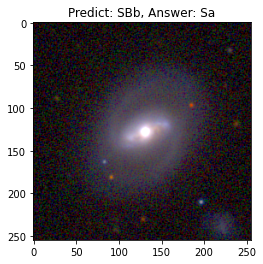

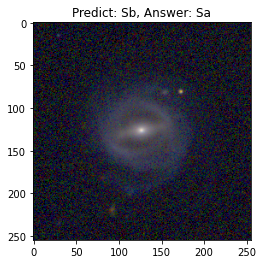

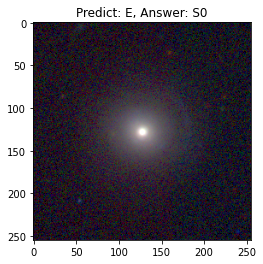

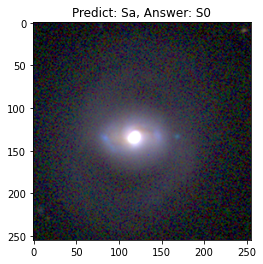

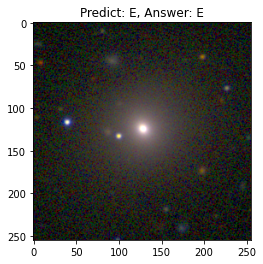

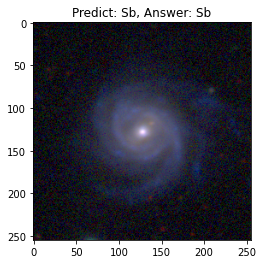

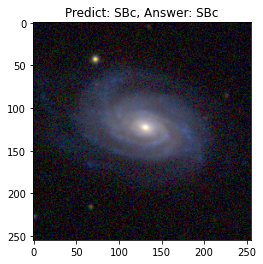

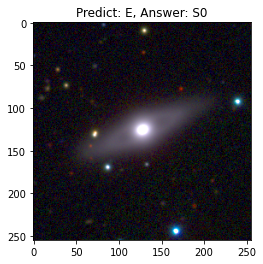

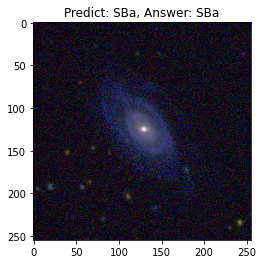

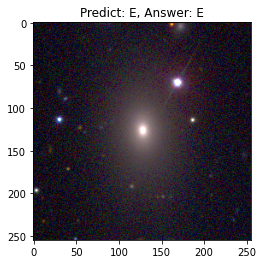

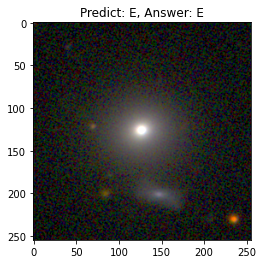

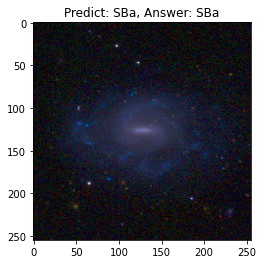

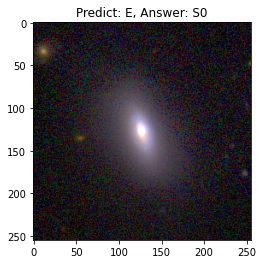

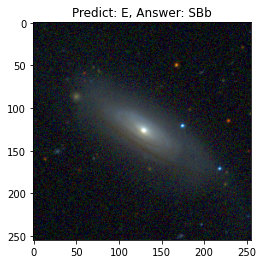

In [11]:
model = torch.load('E_I_S_new.pkl')
galaxy_type = ['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc']
loss_func = nn.CrossEntropyLoss()
i = 0
for x, y in test_loader:
    i += 1
    if train_on_gpu:
        x, y = x.cuda(), y.cuda()
    output = model(x)
    out = output.argmax(dim = 1)
    out = out.to('cpu').numpy()
    ans = galaxy_type[y[0]]
    pre = galaxy_type[out[0]]
    if i % 10 == 0:
        
        plt.figure(i)
        plt.title(f'Predict: {pre}, Answer: {ans}')
#         if out[0] == 0:
            
#         elif out[0] == 1:
#             plt.title(f'Predict: {pre}, Answer: {ans}')
#         else:
#             plt.title(f'Predict: S, Answer: {ans}')
        x = x.squeeze()
        x = x.to('cpu')
        plt.imshow(x.permute(1, 2, 0))
        plt.show()

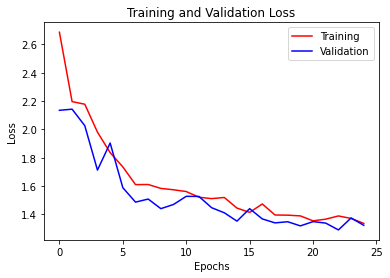

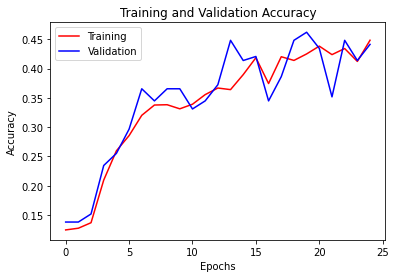

In [12]:
plt.figure(1)
plt.title('Training and Validation Loss')
train_l, = plt.plot(train_loss_record, color = 'red')
val_l, = plt.plot(val_loss_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(handles = [train_l, val_l], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

plt.figure(2)
plt.title('Training and Validation Accuracy')
train_a, = plt.plot(train_acc_record, color = 'red')
val_a, = plt.plot(val_acc_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(handles = [train_a, val_a], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

In [13]:
confmat = confusion_matrix(y_true=actu, y_pred=ai_pred)

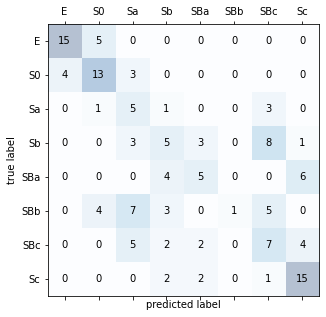

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7],['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc'])
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7],['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc'])
plt.show()